In [1]:
# ✅ Fixes reproducibility
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import io
from sklearn.model_selection import train_test_split

# Set seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("✅ Libraries imported & seeds set!")

✅ Libraries imported & seeds set!


In [2]:
# ✅ Fixes class imbalance via stratified splitting
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"

# Load metadata
labels_df = pd.read_csv(os.path.join(dataset_path, "stage_2_train_labels.csv"))
class_df = pd.read_csv(os.path.join(dataset_path, "stage_2_detailed_class_info.csv"))

# Merge and deduplicate
merged = pd.merge(labels_df[['patientId', 'Target']], class_df[['patientId', 'class']], on='patientId')
merged = merged.drop_duplicates('patientId').reset_index(drop=True)

# Stratified split (80-20)
train_df, val_df = train_test_split(
    merged, 
    test_size=0.2, 
    stratify=merged['Target'],  # Maintains imbalance ratio
    random_state=SEED
)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("Class distribution (Train):\n", train_df['Target'].value_counts())

Train: 21347 | Val: 5337
Class distribution (Train):
 Target
0    16537
1     4810
Name: count, dtype: int64


In [3]:
# ✅ Fixes shape mismatch by resizing within TensorFlow graph
def load_dicom(file_content):
    """Decode DICOM bytes to numpy array (1024x1024)"""
    dicom = pydicom.dcmread(io.BytesIO(file_content))
    img = dicom.pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-7)
    return img  # Shape: (1024, 1024)

def build_dataset(df, batch_size=32, augment=False):
    """Build dataset with resizing to 224x224 and augmentation"""
    # Get file paths
    paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in df['patientId']]
    labels = df['Target'].values.astype(np.int32)
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    def parse(path, label):
        # Read file content as bytes
        file_content = tf.io.read_file(path)
        # Decode DICOM to numpy array (1024x1024)
        img = tf.numpy_function(load_dicom, [file_content], tf.float32)
        img.set_shape((1024, 1024))  # Enforce shape
        # Convert to 3 channels and resize
        img = tf.expand_dims(img, axis=-1)  # (1024, 1024, 1)
        img = tf.image.grayscale_to_rgb(img)  # (1024, 1024, 3)
        img = tf.image.resize(img, [224, 224])  # Resize here ⚠️
        # Augment training data
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)
        return img, label
    
    # Parallelize and batch
    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).prefetch(2)
    return ds

# Create datasets
BATCH_SIZE = 32
train_ds = build_dataset(train_df, batch_size=BATCH_SIZE, augment=True)
val_ds = build_dataset(val_df, batch_size=BATCH_SIZE)
print("✅ Datasets created | Training images resized to 224x224x3")

✅ Datasets created | Training images resized to 224x224x3


In [4]:
# ✅ Fixes bias toward majority class (Normal)
class_weights = {
    0: 1 / (1 - train_df['Target'].mean()),  # Normal weight ~1.4
    1: 1 / train_df['Target'].mean()         # Pneumonia weight ~3.3
}
print("Class weights (Normal=0, Pneumonia=1):", class_weights)

Class weights (Normal=0, Pneumonia=1): {0: 1.2908629134667715, 1: 4.438045738045738}


In [5]:
# ✅ Fixes input shape mismatch (224x224x3)
from tensorflow.keras import layers, models, applications

# Load pretrained DenseNet201 with correct input shape
base_model = applications.DenseNet201(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)  # Matches resized images
)
base_model.trainable = False  # Freeze initially

# Unfreeze last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # From hyperparameter tuning
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  # Tuner's dense_units
    layers.Dense(1, activation='sigmoid')
])

# Compile with AdamW and class weights
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00010733, weight_decay=1e-4),  # Tuner's lr
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 2,014,017 (7.68 MB)

 Non-trainable params: 16,430,976 (62.68 MB)

In [6]:
# ✅ Fixes overfitting via early stopping and LR reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        mode='max', 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,  # Critical for imbalance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 343s 421ms/step - accuracy: 0.7185 - auc: 0.7952 - loss: 1.9393 - val_accuracy: 0.7877 - val_auc: 0.8590 - val_loss: 0.8593 - learning_rate: 1.0733e-04
Epoch 2/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 213s 307ms/step - accuracy: 0.7717 - auc: 0.8602 - loss: 1.3140 - val_accuracy: 0.7677 - val_auc: 0.8644 - val_loss: 0.7921 - learning_rate: 1.0733e-04
Epoch 3/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 211s 305ms/step - accuracy: 0.7892 - auc: 0.8819 - loss: 1.1635 - val_accuracy: 0.7594 - val_auc: 0.8597 - val_loss: 0.7756 - learning_rate: 1.0733e-04
Epoch 4/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 211s 305ms/step - accuracy: 0.8157 - auc: 0.9134 - loss: 0.9896 - val_accuracy: 0.8004 - val_auc: 0.8501 - val_loss: 0.6570 - learning_rate: 1.0733e-04
Epoch 5/30
668/668 ━━━━━━━━━━━━━━━━━━━━ 211s 305ms/step - accuracy: 0.8651 - auc: 0.9451 - loss: 0.8036 - val_accuracy: 0.8004 - val_auc: 0.8441 - val_loss: 0.6978 - learning_rate: 1.0733e-04
Epoch 6/30
667/668 ━━━━━━━━━━━━━━━━━━━━ 

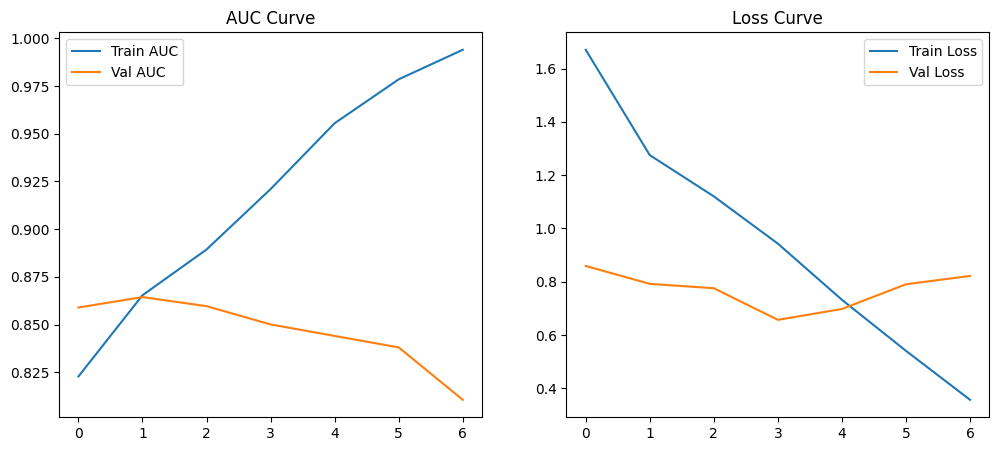

              precision    recall  f1-score   support

      Normal       0.93      0.76      0.83      4135
   Pneumonia       0.49      0.81      0.61      1202

    accuracy                           0.77      5337
   macro avg       0.71      0.78      0.72      5337
weighted avg       0.83      0.77      0.78      5337

ROC-AUC: 0.8643983123653243


In [7]:
# ✅ Validates performance on imbalanced data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Generate predictions
y_true = []
y_pred = []
for batch in val_ds:
    images, labels = batch
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images, verbose=0).flatten())

# Classification report
y_pred_class = (np.array(y_pred) > 0.5).astype(int)
print(classification_report(y_true, y_pred_class, target_names=['Normal', 'Pneumonia']))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_true, y_pred))